In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks

In [ ]:
def make_pairs(images, labels, seed=19):
    np.random.seed(seed)
    pairImages = []
    pairLabels = []

    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]

        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return (np.array(pairImages), np.array(pairLabels))

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = 1 - (trainX / 255.0)
testX  = 1 - (testX / 255.0)

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

print(f'\nTrain Data Shape: {pairTrain.shape}')
print(f'Test  Data Shape: {pairTest.shape}\n\n')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Train Data Shape: (120000, 2, 28, 28, 1)
Test  Data Shape: (20000, 2, 28, 28, 1)




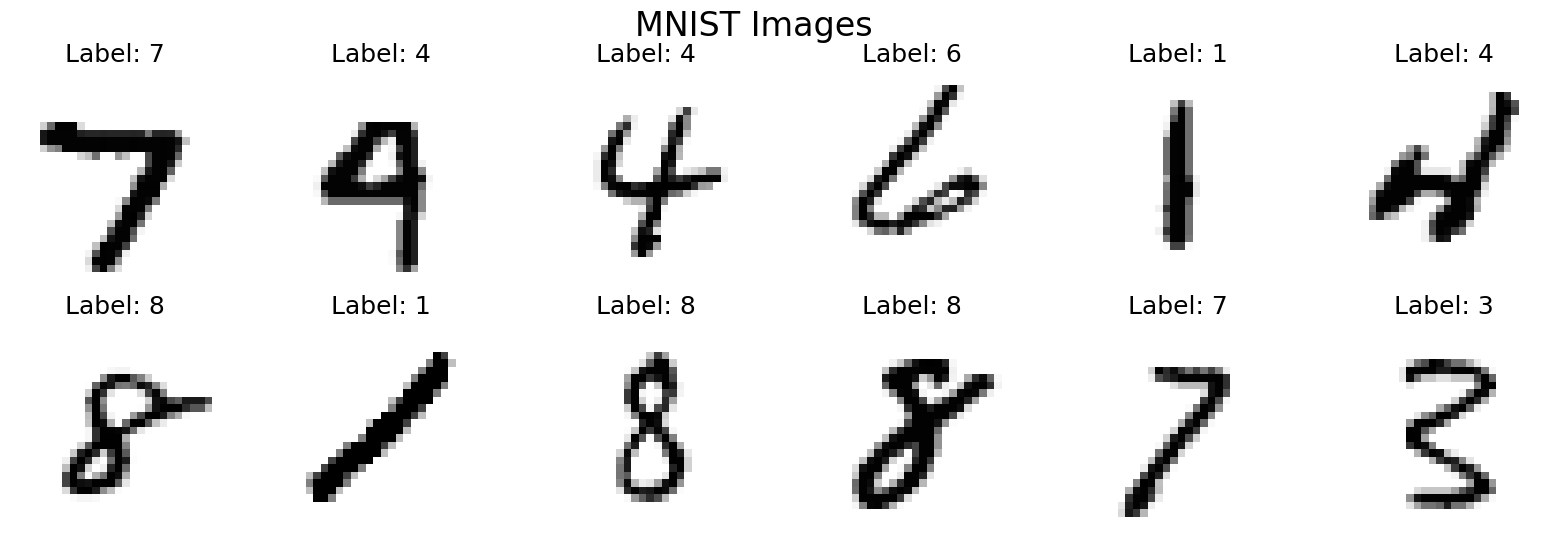

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(trainX)), k=12)
for i in range(12):
    ax[i//6][i%6].imshow(np.squeeze(trainX[idx[i]]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {trainY[idx[i]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
fig.suptitle('MNIST Images', fontsize=24);

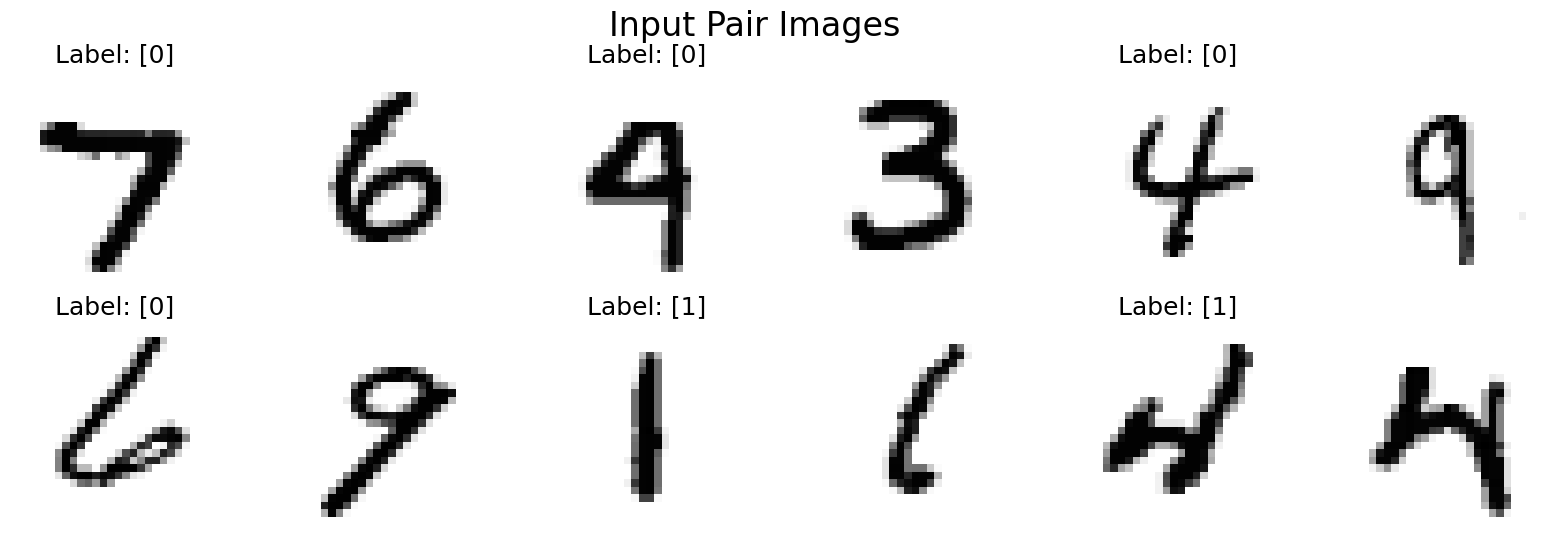

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(pairTrain)), k=6)
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(pairTrain[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(pairTrain[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTrain[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Input Pair Images', fontsize=24);

In [ ]:
class config():
    IMG_SHAPE = (28, 28, 1)
    EMBEDDING_DIM = 48

    BATCH_SIZE = 32
    EPOCHS = 100

def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

class SiameseNetwork(Model):
    def __init__(self, inputShape, embeddingDim):
        super(SiameseNetwork, self).__init__()

        imgA = layers.Input(shape=inputShape)
        imgB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, embeddingDim)
        featsA = featureExtractor(imgA)
        featsB = featureExtractor(imgB)
        distance = layers.Lambda(euclidean_distance, name='euclidean_distance')([featsA, featsB])
        outputs = layers.Dense(1, activation="sigmoid")(distance)
        self.model = Model(inputs=[imgA, imgB], outputs=outputs)

    def build_feature_extractor(self, inputShape, embeddingDim=48):

        model = Sequential([
            layers.Input(inputShape),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(128, (1, 1), padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(embeddingDim, activation='tanh')
        ])

        return model

    def call(self, x):
        return self.model(x)

model = SiameseNetwork(inputShape=config.IMG_SHAPE, embeddingDim=config.EMBEDDING_DIM)
model.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

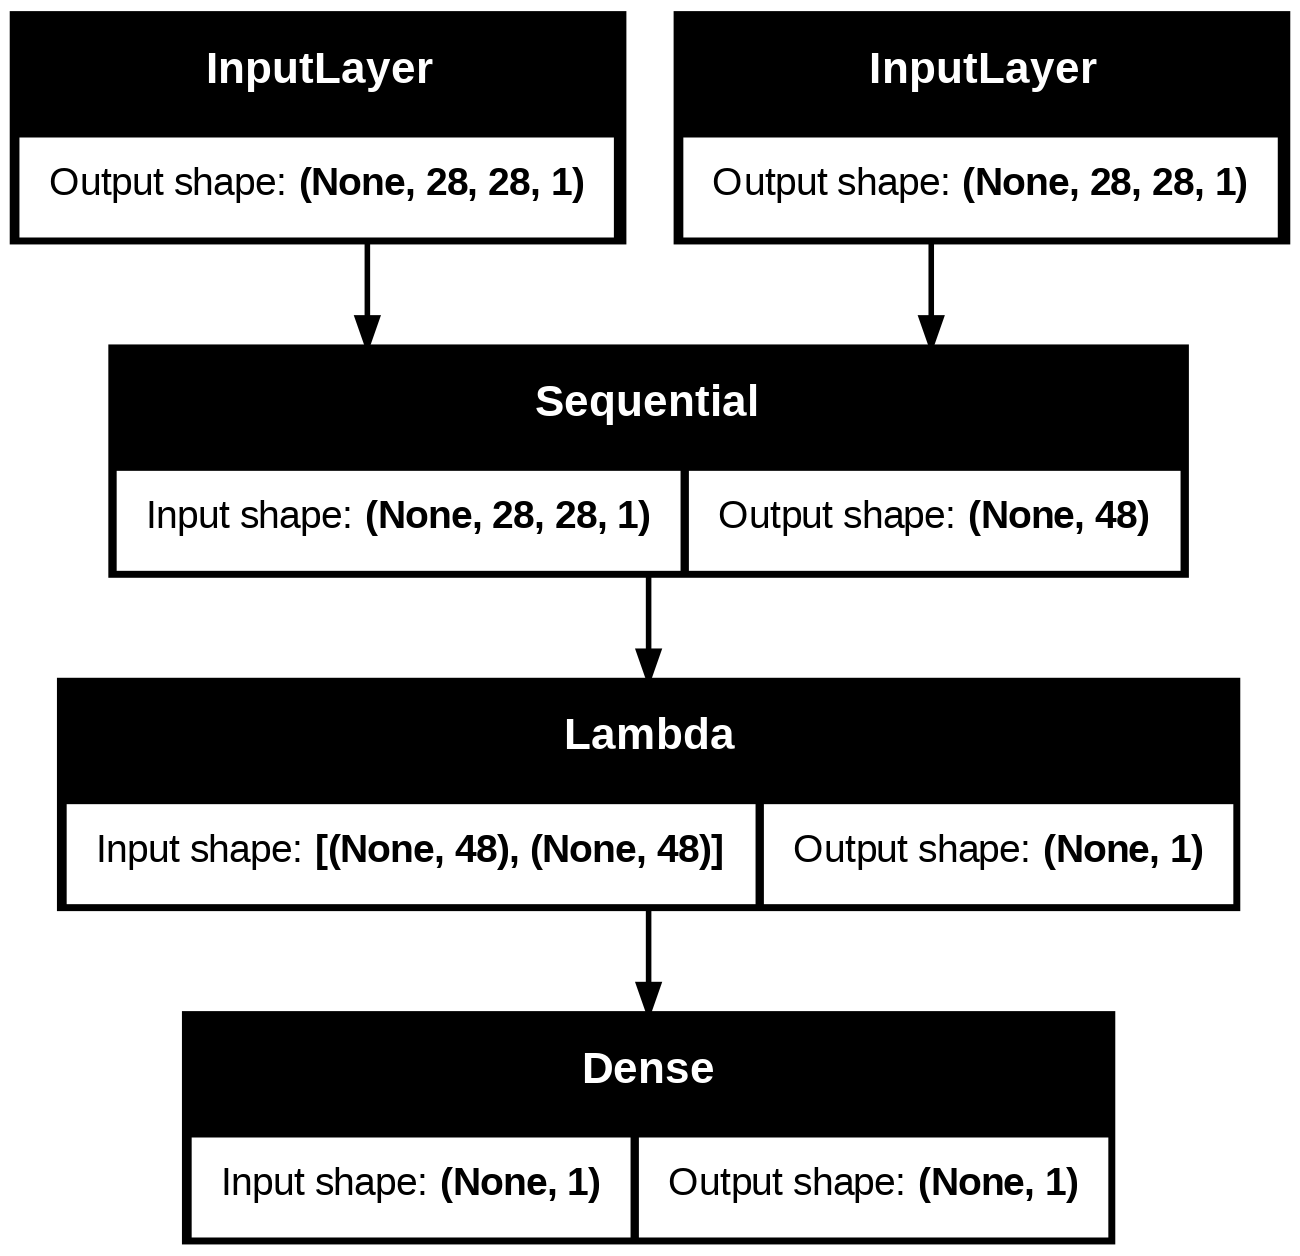

In [ ]:
utils.plot_model(model.model, show_shapes=True, expand_nested=True)

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=1e-4)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1)

history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    callbacks=[es , rlp]
)

Epoch 1/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8085 - loss: 0.1476 - val_accuracy: 0.9089 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 2/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9124 - loss: 0.0807 - val_accuracy: 0.9284 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 3/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9353 - loss: 0.0592 - val_accuracy: 0.9333 - val_loss: 0.0606 - learning_rate: 0.0010
Epoch 4/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9398 - loss: 0.0550 - val_accuracy: 0.9377 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 5/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9455 - loss: 0.0503 - val_accuracy: 0.9317 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 6/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9465 - loss: 0.0492 - val_accuracy: 0.9410 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 7/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accura

In [ ]:
model.summary()

Model: "siamese_network_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)            │ (None, 1)                   │         326,194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 978,584 (3.73 MB)

 Trainable params: 326,194 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 652,390 (2.49 MB)

In [ ]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy*100 :.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy*100 :.2f}%")

Final Training Accuracy: 96.87%
Final Validation Accuracy: 94.60%


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


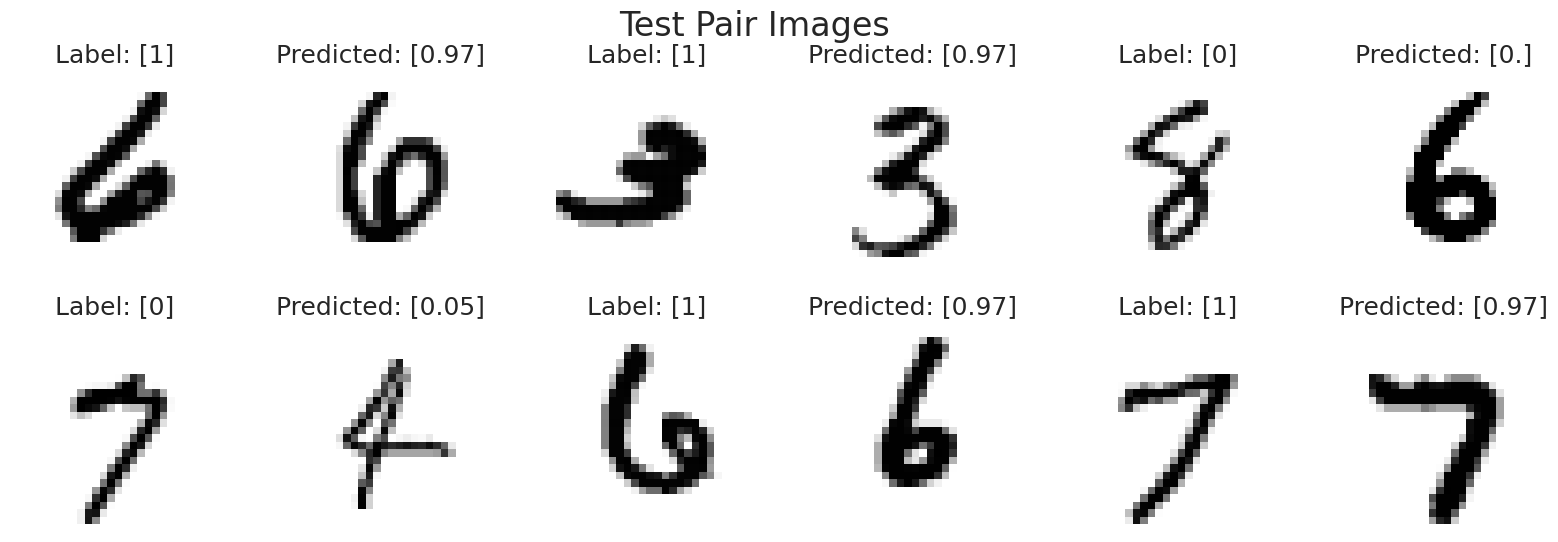

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(pairTest)), k=6)
preds = model.predict([pairTest[:, 0], pairTest[:, 1]])
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(pairTest[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(pairTest[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTest[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6+1].set_title(f'Predicted: {np.round(preds[idx[i//2]], 2)}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Test Pair Images', fontsize=24);

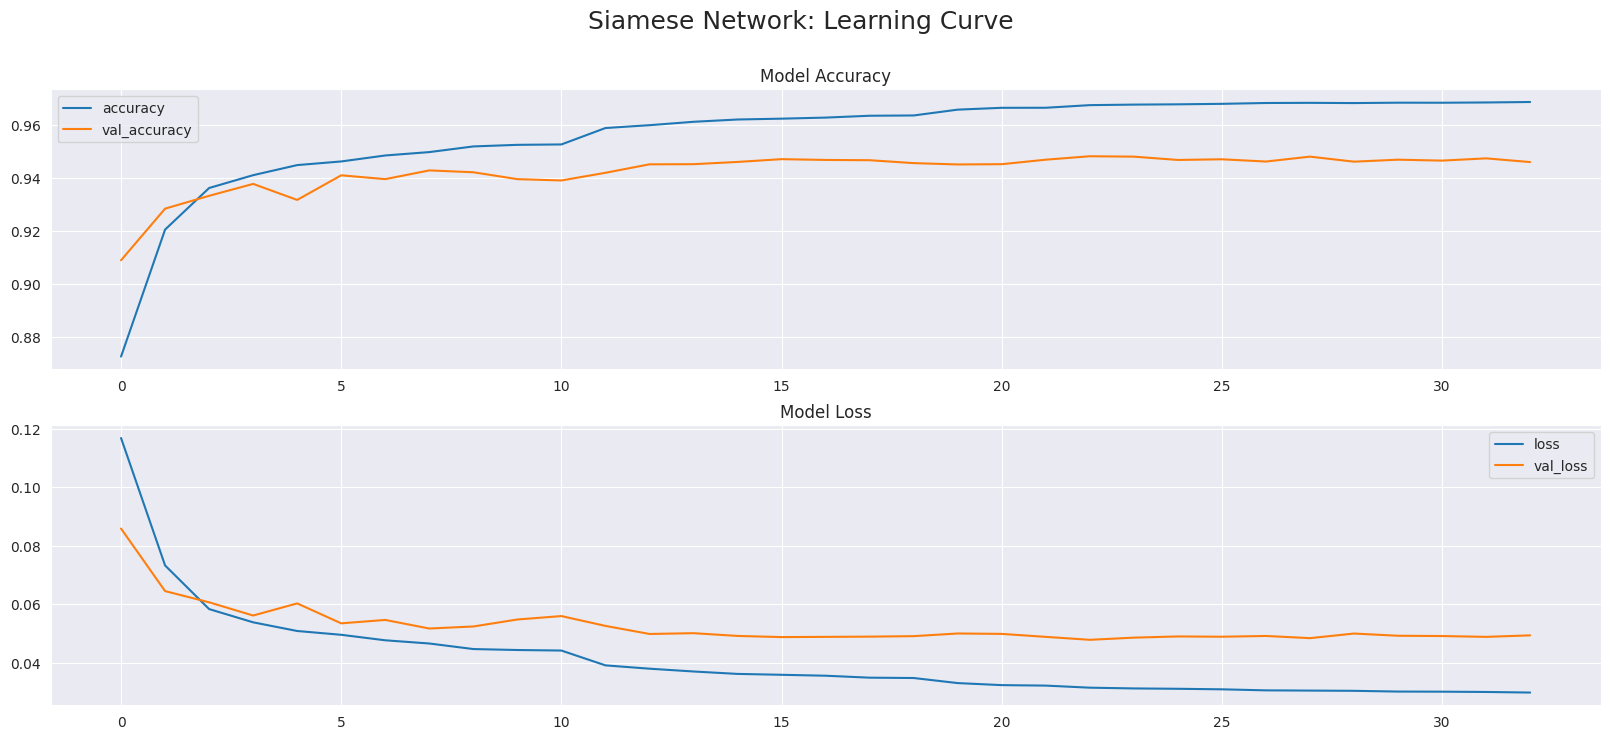

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Siamese Network: Learning Curve', fontsize=18);